In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors  as colors
from sklearn.utils import resample #downsample the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale #scale and center data
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV #thiswilldocrossvalidation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA #to perform PCA the plot the data


In [2]:
url = 'https://raw.githubusercontent.com/swapnasavalgi/Machine-Learning/main/creditcard.csv'
data = pd.read_csv(url, header = 1)

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#default payment next month is the column that we are going to predict . i.e it is our target variable

Attributes Information#
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



In [5]:
data.rename({'default payment next month':'Default'}, axis = 'columns', inplace=True)

In [6]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Identifying missing data

Let's start by making sure if we have correct values for SEX, MARRIAGE, EDUCATION as mentioned in the attributes

In [7]:
data['SEX'].unique()

array([2, 1])

This has only two values, 2 and 1 . ie. Female and Male (as mentioned above) . No changes is required in SEX column

In [8]:
data['MARRIAGE'].unique()

array([1, 2, 3, 0])

In [9]:
data['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

Education has some extra values ie 0,5 and 6 .Similary for Marriage, we can see we have some rows with a value '0'.They are incorrectly filled in our data.

In [10]:
#To remove those unknown values, we will exclude them from our dataframe. Before removing, let's see how many incorrect records we have in the data

len(data.loc[(data['EDUCATION'] == 0) | (data['MARRIAGE'] == 0)])

#data_no_missing = len(data.loc())

68

In [11]:
len(data)

30000

Out of 30,000 we have 68 records that are incorrectly stored.We can remove this 68 records from the data , resulting us to 29,932 records.

In [12]:
data_no_missing = data.loc[(data['EDUCATION'] != 0) & (data['MARRIAGE'] != 0)]

In [13]:
len(data_no_missing)

29932

In [14]:
#We will remove ID column as , it will not help us in building machine learning model.

data_no_missing.drop('ID',axis = 'columns', inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
#Just to make sure we have excluded unknown data correctly , let's re run the unique function again.

print(data_no_missing['EDUCATION'].unique())
print(data_no_missing['MARRIAGE'].unique())

[2 1 3 5 4 6]
[1 2 3]


Downsample the data

Support vectors are good for small datasets but not good for larrge data.This data is not huge, but good enough to take a long time to optimize with cross validation.Therefore , we will downsample both categories -
who did and did not  defualt to 1000 each 

In [16]:
len(data_no_missing)

29932

This is relatively large dataset for support vector machine.TO make sure we get 1000 of each category we start by splitting the data into two dataframes.
1 - People who did not default
2. People who did default

In [17]:
data_no_default = data_no_missing[data_no_missing['Default'] == 0]
data_default = data_no_missing[data_no_missing['Default'] == 1]

Now , downsampe the data with no default

In [18]:
nodefault_downsample = resample(data_no_default,
                              replace = False,
                              n_samples = 1000,
                              random_state = 42)

In [19]:
default_downsample = resample(data_default,
                              replace = False,
                              n_samples = 1000,
                              random_state = 42)

In [20]:
#merge the dataframes

df = pd.concat([nodefault_downsample,default_downsample])
df.head(1)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
641,130000,2,3,1,28,0,0,0,0,-2,-2,100143,50456,50000,0,0,0,2500,1000,0,0,0,0,0


Split the data into Dependent Var and Independent Var

In [21]:
X = df.drop('Default', axis = 1)
Y = df['Default']

In [22]:
X.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

Format the Data - One hot coding

In [25]:
X_enconded = pd.get_dummies(X,columns= ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

Center and Scaling

Radial Basic func (RBF) that we are using for our vector machine, assumes that our data are centered and scaled.

Note:We will split the data into training and testing and then scale them to avoid Data Leakage.

In [29]:
X_train,X_test,Y_train, Y_test = train_test_split(X_enconded, Y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)


Build a prelimnary model

In [30]:
model = SVC(random_state = 42)
model.fit(X_train_scaled, Y_train)

SVC(random_state=42)

We have built a model , let's see how it performs on our test data.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


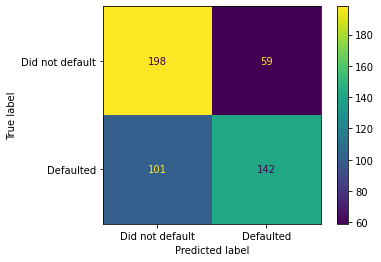

In [33]:
plot_confusion_matrix(model,
                      X_test_scaled,
                      Y_test,
                      values_format = 'd',
                      display_labels = ["Did not default","Defaulted"])

Optimize Parameters with Cross Validation and GridSearch()


In [38]:
param_grid = [{
    'C':[0.5,1,10,100], #C is regularization parameter and C must be > 0
    'gamma' : ['scale',1,0.1,.01,.001,.0001],
    'kernel':['rbf']
}]
#Note we  are including C = 1and gammae = 'scale'

In [39]:
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 0
)

In [42]:
optimal_params.fit(X_train_scaled,Y_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


And we see that the ideale value for C is 10 and ideal val for gamma is 0.001

In [43]:
#We can build model with above values

model = SVC(random_state= 42,C =10, gamma= 0.001)
model.fit(X_train_scaled,Y_train)

SVC(C=10, gamma=0.001, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


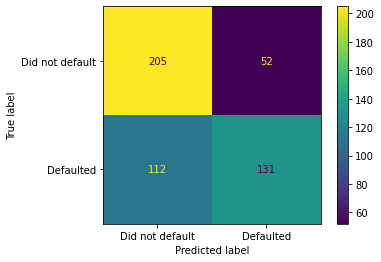

In [44]:
plot_confusion_matrix(model,
                      X_test_scaled,
                      Y_test,
                      values_format = 'd',
                      display_labels = ["Did not default","Defaulted"])

This looks better as 4 more were correctly classified as did not default and 2 were incorrectly classified as defualted.

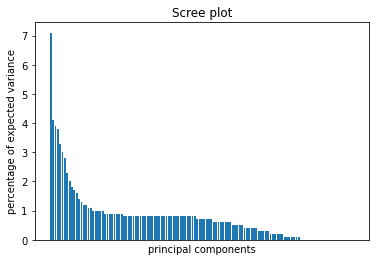

In [45]:
#Since we have 24 features , we can use principal componenet to visualize those 24 features.

pca =PCA()
x_train_pca = pca.fit(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x = range(1, len(per_var)+1), height = per_var)
plt.tick_params(
    
    axis = 'x',
    which = 'both',
    bottom = False,
    top = False,
    labelbottom = False
)

plt.ylabel('percentage of expected variance')
plt.xlabel('principal components')
plt.title('Scree plot')
plt.show()

This graphs is saying that first Principal plot shows a large amount of variation that means it will be a good candidate for the x axis in a  2 dimensional graph